# How good is my Kriging model? - tests with IDW algorithm - tutorial

## Table of Contents:

1. Read point data,
2. Divide dataset into two sets: modeling and validation set,
3. Perform IDW and evaluate it,
4. Perform variogram modeling on the modeling set,
5. Validate Kriging and compare Kriging and IDW validation results,
6. Bonus scenario: only 5% of values are known!

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2021-12-08 | Behavior of `prepare_kriging_data()` function has changed | @SimonMolinsky |
| 2021-05-12 | First version of tutorial | @SimonMolinsky |

## Introduction

In this tutorial we will learn about the one method of validation of our Kriging model. We'll compare it to the Inverse Distance Weighting function where the unknown point value is interpolated as the weighted mean of it's neighbours. Weights are assigned by the inverted distance raised to the n-th power.

(1) **GENERAL FORM OF IDW**

$$z(u) = \frac{\sum_{i}\lambda_{i}*z_{i}}{\sum_{i}\lambda_{i}}$$

where:

- $z(u)$: is the value at unknown location,
- $i$: is a i-th known location,
- $z_{i}$: is a value at known location $i$,
- $\lambda_{i}$: is a weight assigned to the known location $i$.

(2) **WEIGHTING PARAMETER**

$$\lambda_{i} = \frac{1}{d^{p}_{i}}$$

where:

- $d$:  is a distance from known point $z_{i}$ to the unknown point $z(u)$,
- $p$: is a hyperparameter which controls how strong is a relationship between known point and unknown point. You may set large $p$ if you want to show strong relationship between closest point and very weak influence of distant points. On the other hand, you may set small $p$ to emphasize fact that points are influencing each other with the same power irrespectively of their distance.

---

As you noticed **IDW** is a simple but powerful technique. Unfortunately it has major drawback: **we must set `p` - power - manually** and it isn't derived from the data and variogram. That's why it can be used for other tasks. Example is to use IDW as a baseline for comparison to the other techniques.

## Import packages

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pyinterpolate.idw import inverse_distance_weighting  # function for idw
from pyinterpolate.io_ops import read_point_data
from pyinterpolate.semivariance import calculate_semivariance  # experimental semivariogram
from pyinterpolate.semivariance import TheoreticalSemivariogram  # theoretical models
from pyinterpolate.kriging import Krige  # kriging models

## 1) Read point data

In [2]:
dem = read_point_data('../sample_data/point_data/poland_dem_gorzow_wielkopolski', data_type='txt')
dem

array([[15.1152409 , 52.76514556, 91.27559662],
       [15.1152409 , 52.74279035, 96.54829407],
       [15.1152409 , 52.71070647, 51.25455093],
       ...,
       [15.37034993, 52.68338343, 40.30933762],
       [15.37034993, 52.67096386, 21.94326782],
       [15.37034993, 52.64239886, 51.52513504]])

## 2) Divide dataset into two sets: modeling and validation set

In this step we will divide our dataset into two sets:

- modeling set (50%): points used for variogram modeling,
- validation set (50%): points used for prediction and results validation.

Baseline dataset will be divided randomly.

In [3]:
# Create modeling and validation sets

def create_model_validation_sets(dataset: np.array, frac=0.5):
    """
    Function divides base dataset into modeling and validation sets
    
    INPUT:
    :param dataset: (numpy array) array with rows of records,
    :param frac: (float) number of elements in a validation set
    
    OUTPUT:
    return: modeling_set (numpy array), validation_set (numpy array)
    """

    removed_idx = np.random.randint(0, len(dem)-1, size=int(frac * len(dem)))
    validation_set = dem[removed_idx]
    modeling_set = np.delete(dem, removed_idx, 0)
    return modeling_set, validation_set

known_points, unknown_points = create_model_validation_sets(dem)

## 3) Perform IDW and evaluate it

Inverse Distance Weighting doesn't require variogram modeling or other steps. We pass power to which we want raise distance in weight denominator. Things to remember are:

- Large `power` -> closer neighbours are more important,
- `power` which is close to the **zero** -> all neighbours are important and we assume that distant process has the same effect on our variable as the closest events.

In [4]:
IDW_POWER = 2
NUMBER_OF_NEIGHBOURS = -1  # Include all points in weighting process (equation 1)

idw_predictions = []

for pt in unknown_points:
    idw_result = inverse_distance_weighting(known_points, pt[:-1], NUMBER_OF_NEIGHBOURS, IDW_POWER)
    idw_predictions.append(idw_result)

In [5]:
# Evaluation

idw_rmse = np.mean(np.sqrt((unknown_points[:, -1] - np.array(idw_predictions))**2))
print(f'Root Mean Squared Error of prediction with IDW is {idw_rmse}')

Root Mean Squared Error of prediction with IDW is 5.19107490245737


**Clarification:** Obtained Root Mean Squared Error could serve as a baseline for further model development. To build better reference, we create four IDW models of powers:

1. 0.5,
2. 1,
3. 2,
4. 4.

In [6]:
IDW_POWERS = [0.5, 1, 2, 4]
idw_rmse = {}

for pw in IDW_POWERS:
    results = []
    for pt in unknown_points:
        idw_result = inverse_distance_weighting(known_points, pt[:-1], NUMBER_OF_NEIGHBOURS, pw)
        results.append(idw_result)
    idw_rmse[pw] = np.mean(np.sqrt((unknown_points[:, -1] - np.array(results))**2))

In [7]:
for pw in IDW_POWERS:
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {idw_rmse[pw]:.4f}')

Root Mean Squared Error of prediction with IDW of power 0.5 is 17.6443
Root Mean Squared Error of prediction with IDW of power 1 is 14.6930
Root Mean Squared Error of prediction with IDW of power 2 is 5.1911
Root Mean Squared Error of prediction with IDW of power 4 is 1.8930


## 4) Perform variogram modeling on the modeling set

In this step we will go through semivariogram modeling for Kriging interpolation.

In [8]:
search_radius = 0.01
max_range = 0.32
number_of_ranges = 32

exp_semivar = calculate_semivariance(data=known_points, step_size=search_radius, max_range=max_range)

In [9]:
semivar = TheoreticalSemivariogram(points_array=known_points, empirical_semivariance=exp_semivar)
semivar.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)

'linear'

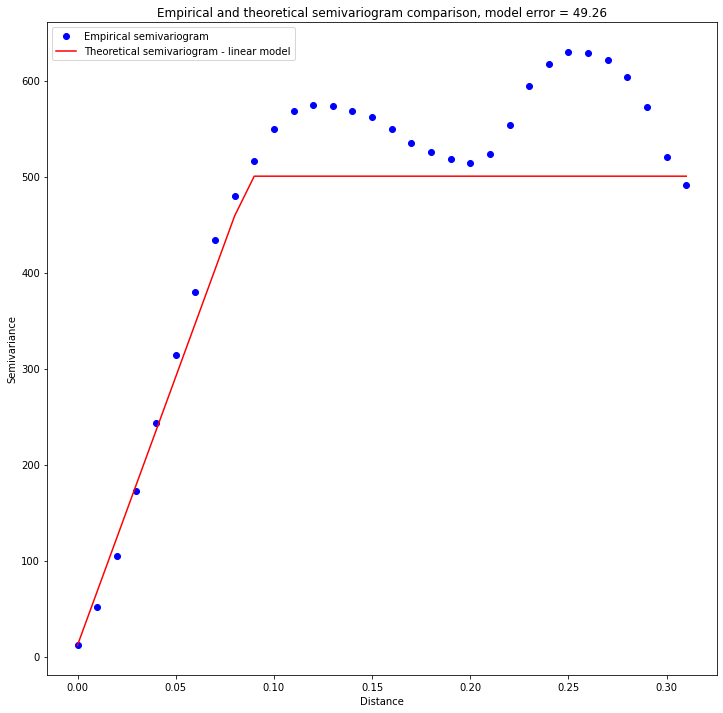

In [10]:
semivar.show_semivariogram()

## 5) Validate Kriging and compare Kriging and IDW validation results

In the last we perform Kriging interpolation and compare rersults to the **IDW** models. We use all points to weight values at unknown locations and semivariogram model chosen in the previous step.

In [11]:
# Set Kriging model

model = Krige(semivariogram_model=semivar, known_points=known_points)

In [12]:
kriging_preds = []

for pt in unknown_points:
    
    result = model.ordinary_kriging(pt[:-1], test_anomalies=False)
    kriging_preds.append(result[0])

In [13]:
# Evaluation

kriging_rmse = np.mean(np.sqrt((unknown_points[:, -1] - np.array(kriging_preds))**2))
print(f'Root Mean Squared Error of prediction with Kriging is {kriging_rmse}')

Root Mean Squared Error of prediction with Kriging is 1.7118337970412345


**Clarification**: Kriging is better than any from the IDW models and we may assume that our modeling approach gives us more insights into the spatial process which we are observing. But this is not the end... let's consider more complex scenario!

## 6) Bonus scenario: only 5% of values are known!

Real world data are rarely as good as sample from the tutorial. It is too expensive to densily sample every location and usually we get only small percent of area covered by data. That's why it is good to compare **IDW vs Kriging** in this scenario! We repeat steps 1-5 with change in division for modeling / validation set. (I encourage you to try it do alone and then compare your code and results with those given in this notebook).

In [15]:
# Data preparation

known_points, unknown_points = create_model_validation_sets(dem, 0.95)

In [16]:
# IDW tests

IDW_POWERS = [0.5, 1, 2, 4]
idw_rmse = {}

for pw in IDW_POWERS:
    results = []
    for pt in unknown_points:
        idw_result = inverse_distance_weighting(known_points, pt[:-1], NUMBER_OF_NEIGHBOURS, pw)
        results.append(idw_result)
    idw_rmse[pw] = np.mean(np.sqrt((unknown_points[:, -1] - np.array(results))**2))

In [17]:
# Variogram

search_radius = 0.01
max_range = 0.32
number_of_ranges = 32

exp_semivar = calculate_semivariance(data=known_points, step_size=search_radius, max_range=max_range)

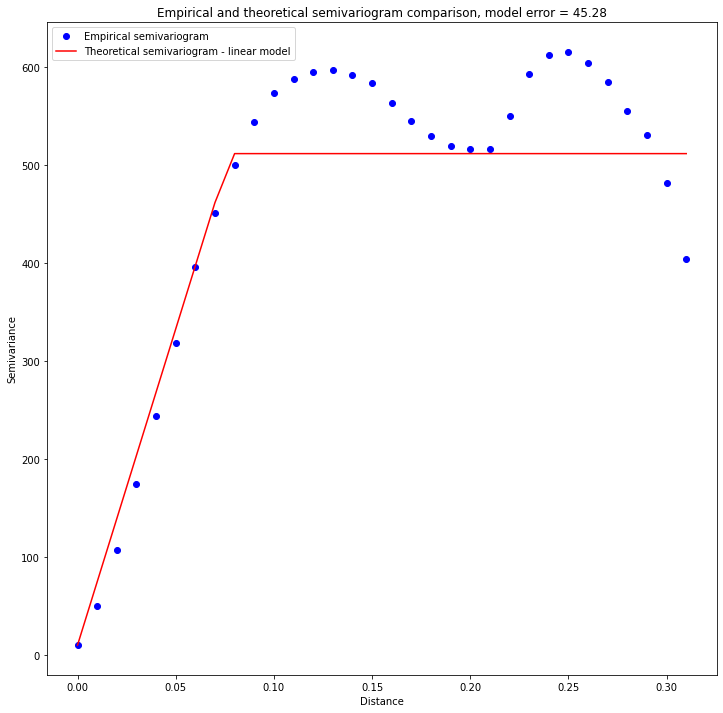

In [18]:
semivar = TheoreticalSemivariogram(points_array=known_points, empirical_semivariance=exp_semivar)
semivar.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)
semivar.show_semivariogram()

In [19]:
# Set Kriging model

model = Krige(semivariogram_model=semivar, known_points=known_points)

In [20]:
kriging_preds = []

for pt in unknown_points:
    
    result = model.ordinary_kriging(pt[:-1], min_no_neighbors=16, test_anomalies=False)
    kriging_preds.append(result[0])

kriging_rmse = np.mean(np.sqrt((unknown_points[:, -1] - np.array(kriging_preds))**2))

In [21]:
# Comparison

for pw in IDW_POWERS:
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {idw_rmse[pw]:.4f}')
print(f'Root Mean Squared Error of prediction with Kriging is {kriging_rmse:.4f}')

Root Mean Squared Error of prediction with IDW of power 0.5 is 17.6009
Root Mean Squared Error of prediction with IDW of power 1 is 14.6137
Root Mean Squared Error of prediction with IDW of power 2 is 5.4637
Root Mean Squared Error of prediction with IDW of power 4 is 2.1395
Root Mean Squared Error of prediction with Kriging is 1.9805


Your results may be different but in the most cases Kriging will be better than IDW. What's even more important is the fact that for the single data source with low number of samples we don't have opportunity to perform validation step and we're not able to guess how big should be the power parameter. With Kriging we model variogram and _voila!_ - model works.

---